## Determination of Negative Modes

The purpose of this notebook is to determine the negative modes of the connected wormhole solution.

In [205]:
import numpy as np

In [206]:
def cheb(N):
    """Chebyshev polynomial differentiation matrix."""
    x = np.cos(np.pi * np.arange(0, N + 1) / N)

    if N % 2 == 0:
        x[N // 2] = 0.0 # only when N is even!

    c = np.ones(N + 1)
    c[0] = 2.0
    c[N] = 2.0
    c = c * (-1.0) ** np.arange(0, N + 1)
    c = c.reshape(N + 1, 1)

    X = np.tile(x.reshape(N + 1, 1), (1, N + 1))
    dX = X - X.T
    D = np.dot(c, 1.0 / c.T) / (dX + np.eye(N + 1))
    D = D - np.diag(D.sum(axis=1))

    return D, x

In [207]:
def cheb_2(N, x_minus, x_plus):
    def get_a(x, j):
        a = 1
        for k in range(len(x)):
            if k != j:
                a *= x[j] - x[k]
        return a

    x = (x_plus + x_minus) / 2 + (x_plus - x_minus) / 2 * np.cos(np.pi * np.arange(0, N + 1) / N)

    D = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        a_i = get_a(x, i)
        for j in range(N + 1):
            if j != i:
                # diagonal element
                D[i, i] += 1 / (x[i] - x[j])
                # off diagonal element
                a_j = get_a(x, j)
                D[i, j] = a_i / (a_j * (x[i] - x[j]))

    return D, x

In [219]:
y_minus = 0
y_plus = 0.9
N = 50

In [220]:
D, y_array = cheb_2(N, y_minus, y_plus)

In [276]:
y_array

array([9.00000000e-01, 8.99112028e-01, 8.96451616e-01, 8.92029263e-01,
       8.85862423e-01, 8.77975432e-01, 8.68399419e-01, 8.57172174e-01,
       8.44338006e-01, 8.29947566e-01, 8.14057647e-01, 7.96730959e-01,
       7.78035882e-01, 7.58046198e-01, 7.36840795e-01, 7.14503364e-01,
       6.91122058e-01, 6.66789153e-01, 6.41600681e-01, 6.15656049e-01,
       5.89057647e-01, 5.61910449e-01, 5.34321592e-01, 5.06399955e-01,
       4.78255734e-01, 4.50000000e-01, 4.21744266e-01, 3.93600045e-01,
       3.65678408e-01, 3.38089551e-01, 3.10942353e-01, 2.84343951e-01,
       2.58399319e-01, 2.33210847e-01, 2.08877942e-01, 1.85496636e-01,
       1.63159205e-01, 1.41953802e-01, 1.21964118e-01, 1.03269041e-01,
       8.59423525e-02, 7.00524335e-02, 5.56619940e-02, 4.28278264e-02,
       3.16005814e-02, 2.20245677e-02, 1.41375775e-02, 7.97073717e-03,
       3.54838441e-03, 8.87972207e-04, 0.00000000e+00])

In [221]:
D2 = np.dot(D, D)

### Eigenvalue Problem

In [106]:
import sympy

sympy.init_printing()

In [161]:
r, r_0, L, lam = sympy.symbols("r r_0 L lambda")

In [135]:
# spherical part of the metric
g = sympy.Function("g")(r)
dg = sympy.diff(g, r)

# solution
g_sol = r ** 2 + r_0 ** 2
dg_sol = sympy.diff(g_sol, r)

In [136]:
# radial part of the metric
f = sympy.Function("f")(r)
df = sympy.diff(f, r)

# solution
f_sol = (L ** 2 + r ** 2 + 2 * r_0 ** 2) / L ** 2
df_sol = sympy.diff(f_sol, r)

In [255]:
# gauge field
Phi = sympy.Function("Phi")(r)
dPhi = sympy.diff(Phi, r)
ddPhi = sympy.diff(dPhi, r)

In [280]:
q = sympy.Function("q")(r)
dq = sympy.diff(q, r)
ddq = sympy.diff(dq, r)

K = sympy.Function("K")(r)
dK = sympy.diff(K, r)
K_sol = 6 * L ** 2 * r ** 2 / (r ** 2 - g * L ** 2 * dPhi ** 2)

V = sympy.Function("V")(r)
V_sol = (4 * K_sol / g) * ((2 * g) / (L ** 2 * f * r) * ((L ** 2 * (r - L ** 2 * Phi * dPhi) + g * (r - 2 * L ** 2 * Phi * dPhi)) / (r ** 2 - g * L ** 2 * dPhi ** 2)) - 1)

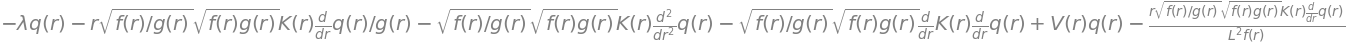

In [140]:
eigen = -sympy.sqrt(f / g) * sympy.diff(sympy.sqrt(f * g) * K * dq, r) + V * q - lam * q
eigen.expand().subs({dg: dg_sol, df: df_sol})

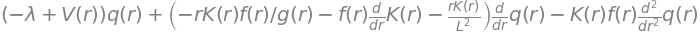

In [239]:
eigen = -lam * q - r * f * K * dq / g - f * K * ddq - f * dK * dq + V * q - r * K * dq / L ** 2
eigen.collect([q, dq])

#### Discretize

The idea is to tune r_0, the length of the wormhole throat, and determine the eigenvalue. Since r_0 = bL, this amounts to tuning b. Therefore, all functions should depend on b.

For numerical convenience, we will make the change of variables r = r_0 * y / (1 - y) = bLy / (1 - y).

In [295]:
y, b = sympy.symbols("y b")

# these will be used to express Phi derivatives in terms of y
Phi_y = sympy.Function("Phi")(y)
dPhi_y = sympy.Function("dPhi")(y)
ddPhi_y = sympy.Function("ddPhi")(y)

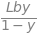

In [246]:
r_in_terms_of_y = b * L * y / (1 - y)
r_in_terms_of_y

In [247]:
r_0_in_terms_of_b = b * L

##### ddq term

In [277]:
ddq_factor = -K * f
ddq_factor

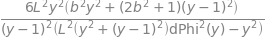

In [166]:
ddq_factor = ddq_factor.subs({K: K_sol, g: g_sol, f: f_sol}).subs({r_0: r_0_in_terms_of_b, dPhi: dPhi_y, r: r_in_terms_of_y}).simplify()
ddq_factor

In [186]:
from scipy.special import ellipkinc

def dphi_of_r(y_val, b_val, L_val):
    """Get radial derivative of gauge field."""
    a = np.sqrt(2 * b_val ** 2 + 1)
    phi_star = np.sqrt(a ** 4 - 1) / 4
    r_val = L_val * b_val * y_val / (1 - y_val)
    phi = np.arctan(r_val / (L_val * a))
    m = 1 - a ** 2 / b_val ** 2
    denom = np.sqrt((L_val * a * b_val) ** 2 + (a ** 2 + b_val ** 2) * r_val ** 2 + r_val ** 4 / L_val ** 2)
    return phi_star * np.sinh((2 / b_val) * ellipkinc(phi, m)) * 2 / denom

In [224]:
b_val = 1.25
L_val = 1

In [229]:
ddq_factors_num = []

for y_val in y_array:
    dPhi_y_val = dphi_of_r(y_val, b_val, L_val)
    ddq_factors_num.append(ddq_factor.subs({b: b_val, y: y_val, L: L_val, dPhi_y: dPhi_y_val}))

ddq_factor_mat = np.diag(ddq_factors_num)
ddq_factor_mat

array([[-785.658900416130, 0, 0, ..., 0, 0, 0],
       [0, -770.903753801626, 0, ..., 0, 0, 0],
       [0, 0, -729.033037866885, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., -62.2462187467288, 0, 0],
       [0, 0, 0, ..., 0, -62.2465160472145, 0],
       [0, 0, 0, ..., 0, 0, -24.7500000000000]], dtype=object)

In [230]:
ddq_factor_total = np.dot(ddq_factor_mat, D2)
ddq_factor_total

array([[-1616581840.96856, 2569612714.80453, -1390832110.40836, ...,
        -6489311.58997507, 6470121.68899733, -3231870.93356353],
       [-733509301.718049, 1049231429.09935, -380839250.171994, ...,
        -486145.145547110, 484699.575679972, -242109.497988364],
       [43483028.7961180, -167545229.704584, 205502709.290713, ...,
        116422.233673913, -116070.966551350, 57977.0972516126],
       ...,
       [4950.19414810734, -9910.35851439841, 9940.35036526631, ...,
        17546209.7478924, -14305328.3959220, 3712663.18757325],
       [-19549.0976368885, 39136.9996148648, -39253.7219521058, ...,
        -30750812.1219230, 84720045.3579269, -59227106.2308493],
       [-101811.111111115, 203823.200778187, -204427.725272143, ...,
        -43814299.9644960, 80948506.6072907, -50925917.7777767]],
      dtype=object)

##### dq term

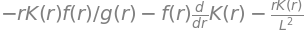

In [282]:
dq_factor = -r * K * f / g - r * K / L ** 2 - f * dK
dq_factor

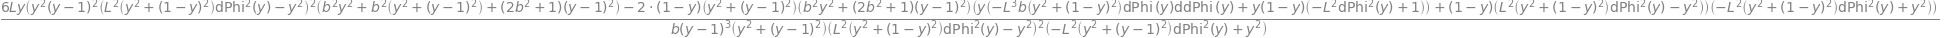

In [283]:
dq_factor = dq_factor.subs({K: K_sol, g: g_sol, f: f_sol}).simplify().subs({r_0: r_0_in_terms_of_b, dPhi: dPhi_y, ddPhi: ddPhi_y, r: r_in_terms_of_y}).simplify()
dq_factor

In [270]:
def ddphi_of_r(r_val, b_val, L_val):
    """Get second derivative of gauge field."""
    a = np.sqrt(2 * b_val ** 2 + 1)
    phi_star = np.sqrt(a ** 4 - 1) / 4
    r_val = L_val * b_val * y_val / (1 - y_val)

    phi = np.arctan2(r_val, (L_val * a))
    m = 1 - a ** 2 / b_val ** 2
    sin_part = np.sinh((2 / b_val) * ellipkinc(phi, m))
    cos_part = np.cosh((2 / b_val) * ellipkinc(phi, m))

    first_term = 2 * L_val * (a ** 2 * L_val ** 2 + r_val ** 2) ** 2 * cos_part / (b_val ** 2 * L_val ** 2 + r_val ** 2)

    fac1 = a ** 2 * L_val ** 2 + b_val ** 2 * L_val ** 2 + 2 * r_val ** 2
    fac2 = a ** 2 * (b_val ** 2 * L_val ** 2 + r_val ** 2) / (b_val ** 2 * (a ** 2 * L_val ** 2 + r_val ** 2))
    second_term = a ** 3 * r_val * fac1 * sin_part / (b_val ** 3 * fac2 ** (3. / 2))

    return 2 * L_val * phi_star * (first_term - second_term) / (a ** 2 * L_val ** 2 + r_val ** 2) ** 3

In [284]:
dq_factors_num = []

for y_val in y_array:
    dPhi_y_val = dphi_of_r(y_val, b_val, L_val)
    ddPhi_y_val = ddphi_of_r(y_val, b_val, L_val)
    dq_factors_num.append(dq_factor.subs({b: b_val, y: y_val, L: L_val, dPhi_y: dPhi_y_val, ddPhi_y: ddPhi_y_val}))

dq_factor_mat = np.diag(dq_factors_num)
dq_factor_mat

array([[-136.129265197060, 0, 0, ..., 0, 0, 0],
       [0, -134.816753788687, 0, ..., 0, 0, 0],
       [0, 0, -131.019619106546, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0.0322943858985961, 0, 0],
       [0, 0, 0, ..., 0, 0.00806077269355366, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [285]:
dq_factor_total = np.dot(dq_factor_mat, D)
dq_factor_total

array([[-252141.650092782, 306607.040358580, -76727.4621495561, ...,
        -303.706887977963, 302.808239661184, -151.254739107837],
       [-75912.7102648831, 37918.8690490604, 50675.1373819095, ...,
        150.538439992083, -150.092566493130, 74.9721667719501],
       [18461.8694064335, -49247.8643148197, 9194.39630648703, ...,
        -146.734399127392, 146.298501591063, -73.0767934530923],
       ...,
       [-0.0180123418469649, 0.0360604030067128, -0.0361678452611353,
        ..., 2.26628183207399, -12.1388655051056, 4.55057600599471],
       [0.00448262977492512, -0.00897412248472883, 0.00900078152245313,
        ..., 3.02989615289548, 2.26719139581194, -4.53886542139912],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

##### q term

In [279]:
q_factor = V
q_factor

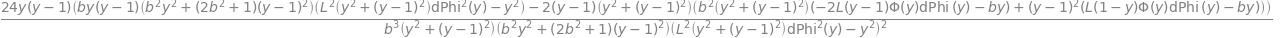

In [296]:
q_factor = V.subs({V: V_sol}).subs({f: f_sol, g: g_sol, Phi: Phi_y, dPhi: dPhi_y}).subs({r_0: r_0_in_terms_of_b, r: r_in_terms_of_y}).simplify()
q_factor

In [297]:
def phi_of_r(r_val, b_val, L_val):
    """Get gauge field."""
    a = np.sqrt(2 * b_val ** 2 + 1)
    phi_star = np.sqrt(a ** 4 - 1) / 4
    r_val = L_val * b_val * y_val / (1 - y_val)
    phi = np.arctan2(r_val, L_val * a)
    m = 1 - a ** 2 / b_val ** 2
    return phi_star * np.cosh((2 / b_val) * ellipkinc(phi, m))

In [298]:
q_factors_num = []

for y_val in y_array:
    Phi_y_val = phi_of_r(y_val, b_val, L_val)
    dPhi_y_val = dphi_of_r(y_val, b_val, L_val)
    q_factors_num.append(q_factor.subs({b: b_val, y: y_val, L: L_val, Phi_y: Phi_y_val, dPhi_y: dPhi_y_val}))

q_factor_mat = np.diag(q_factors_num)
q_factor_mat

array([[0.179695878172427, 0, 0, ..., 0, 0, 0],
       [0, 0.183028514013328, 0, ..., 0, 0, 0],
       [0, 0, 0.193191415606578, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., -23.5522681550682, 0, 0],
       [0, 0, 0, ..., 0, -23.5530052070651, 0],
       [0, 0, 0, ..., 0, 0, nan]], dtype=object)

##### Total

In [331]:
A = ddq_factor_total + dq_factor_total + q_factor_mat
A

array([[-1616833982.43896, 2569919321.84489, -1390908837.87051, ...,
        -6489615.29686305, 6470424.49723699, -3232022.18830264],
       [-733585214.428314, 1049269348.15143, -380788575.034612, ...,
        -485994.607107118, 484549.483113479, -242034.525821592],
       [43501490.6655244, -167594477.568899, 205511903.880211, ...,
        116275.499274785, -115924.668049759, 57904.0204581595],
       ...,
       [4950.17613576550, -9910.32245399541, 9940.31419742104, ...,
        17546188.4619061, -14305340.5347875, 3712667.73814925],
       [-19549.0931542587, 39136.9906407423, -39253.7129513243, ...,
        -30750809.0920268, 84720024.0721131, -59227110.7697147],
       [-101811.111111115, 203823.200778187, -204427.725272143, ...,
        -43814299.9644960, 80948506.6072907, nan]], dtype=object)

Replace bottom row with boundary condition q'(0) = 0.

In [332]:
A[-1] = D[-1]
A = A.astype(float)
A

array([[-1.61683398e+09,  2.56991932e+09, -1.39090884e+09, ...,
        -6.48961530e+06,  6.47042450e+06, -3.23202219e+06],
       [-7.33585214e+08,  1.04926935e+09, -3.80788575e+08, ...,
        -4.85994607e+05,  4.84549483e+05, -2.42034526e+05],
       [ 4.35014907e+07, -1.67594478e+08,  2.05511904e+08, ...,
         1.16275499e+05, -1.15924668e+05,  5.79040205e+04],
       ...,
       [ 4.95017614e+03, -9.91032245e+03,  9.94031420e+03, ...,
         1.75461885e+07, -1.43053405e+07,  3.71266774e+06],
       [-1.95490932e+04,  3.91369906e+04, -3.92537130e+04, ...,
        -3.07508091e+07,  8.47200241e+07, -5.92271108e+07],
       [-1.11111111e+00,  2.22441691e+00, -2.23101835e+00, ...,
        -5.63636791e+02,  2.25232275e+03, -1.85222222e+03]])

In [333]:
B = np.identity(len(y_array))
B

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [334]:
B[-1] = 0
B

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [335]:
from scipy import linalg

In [336]:
linalg.eigvals(A, B)

array([-8.07097303e+07    +0.j        , -4.16171775e+07    +0.j        ,
       -2.30645567e+07    +0.j        ,  2.73981814e+07    +0.j        ,
       -1.32315747e+07    +0.j        ,  1.03548133e+07    +0.j        ,
       -7.76075262e+06    +0.j        , -4.62728216e+06    +0.j        ,
        4.58500112e+06    +0.j        , -2.79382572e+06    +0.j        ,
        2.89124035e+06    +0.j        , -1.70152036e+06    +0.j        ,
        1.87278927e+06    +0.j        , -1.04033448e+06    +0.j        ,
        1.40100776e+06    +0.j        , -6.33880005e+05    +0.j        ,
        1.06063539e+06    +0.j        ,  8.68693137e+05    +0.j        ,
       -3.83392900e+05    +0.j        ,  7.19924532e+05    +0.j        ,
        6.22869621e+05    +0.j        ,  5.41348704e+05    +0.j        ,
        4.73120490e+05    +0.j        , -2.16629024e+05    +0.j        ,
        4.11213090e+05    +0.j        ,  3.55747453e+05    +0.j        ,
        3.05869788e+05    +0.j        , -1.51552344